# Exploring Structure in Chinese Noun Embeddings

---

This project investigates how Chinese nouns organise in embedding space, using clustering and dimensionality reduction to uncover underlying linguistic patterns. 

The goal was to explore whether semantic categories emerge naturally from contextual embeddings, and to what extent structural properties of Chinese, such as single-character morphology, influence the organisation of meaning.  

---

This notebook uses the [**SUBTLEX-CH**](http://www.ugent.be/pp/experimentele-psychologie/en/research/documents/subtlexch) subtitle corpus for Chinese word frequencies. The raw files are not tracked in git, but the pre-processed `nouns_top2500.csv` is included.

**To regenerate from scratch:**
1. Download `SUBTLEX-CH-WF_PoS.xlsx` from [**SUBTLEX-CH**](http://www.ugent.be/pp/experimentele-psychologie/en/research/documents/subtlexch) and place in the `data/` directory
3. Delete `data/nouns_top2500.csv`
4. Run the cells below

## Setup

### Import Libraries

In [1]:
import os
import time
import pickle

# Data
import pandas as pd
import numpy as np

# Translation
from deep_translator import GoogleTranslator

# Clustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Visualisation
import matplotlib.pyplot as plt

# Helper functions
from helper_functions import (
    generate_embeddings,
    run_clustering,
    run_clustering_grid_search,
    run_pca_grid_search,
    compute_enhanced_metrics,
    plot_pca_enhanced_analysis,
    get_representative_nouns,
    print_representative_nouns,
    display_clusters_side_by_side
)

/opt/anaconda3/envs/hanzi/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

In [2]:
# Load from existing CSV if available
if os.path.exists('data/nouns_top2500.csv'):
    print("Loading existing nouns_top2500.csv...")
    df_noun_top2500 = pd.read_csv('data/nouns_top2500.csv')
else:
    # Process from source XLSX file
    print("Processing SUBTLEX-CH-WF_PoS.xlsx to create nouns_top2500.csv...")
    df_pos = pd.read_excel('data/SUBTLEX-CH-WF_PoS.xlsx', skiprows=2)
    df_pos.columns = ['Lemma', 'WF_Lemma', 'WordForm', 'PoS', 'WF_PoS']

    df_noun = df_pos[df_pos['PoS'] == 'n']
    df_noun = df_noun.drop(columns=['PoS', 'Lemma', 'WF_Lemma'])
    df_noun = df_noun.sort_values('WF_PoS', ascending=False)

    df_noun_top2500 = df_noun.head(2500)
    df_noun_top2500 = df_noun_top2500.rename(columns={'WordForm': 'Noun'})
    df_noun_top2500 = df_noun_top2500.rename(columns={'WF_PoS': 'Frequency'})
    
    df_noun_top2500.to_csv('data/nouns_top2500.csv', index=False)
    print("Created and saved nouns_top2500.csv")

print(f"Loaded {len(df_noun_top2500)} nouns")

Loading existing nouns_top2500.csv...
Loaded 2500 nouns


### Add Translations

In [3]:
# Load the nouns dataframe
df_noun_top2500 = pd.read_csv('data/nouns_top2500.csv')

# Initialize translator
translator = GoogleTranslator(source='zh-CN', target='en')

# Add English column if it doesn't already exist
if 'English' not in df_noun_top2500.columns:
    df_noun_top2500['English'] = ''

# Translate any missing entries
translated_count = 0
for i, row in df_noun_top2500.iterrows():

    if pd.notna(row['English']) and row['English'] != '':
        continue
    
    word = row['Noun']
    try:
        equivalent = translator.translate(word).strip().lower()
    except Exception as e:
        print(f"Error translating {word}: {e}")
        equivalent = 'N/A'
    
    df_noun_top2500.at[i, 'English'] = equivalent
    translated_count += 1
    
    time.sleep(0.1)

    if translated_count % 100 == 0:
        print(f"Translated {translated_count} words...")

print(f"Total words translated: {translated_count}/{len(df_noun_top2500)}\n")

# Save the updated dataframe
df_noun_top2500.to_csv('data/nouns_top2500.csv', index=False)
print(df_noun_top2500.head(10))

Total words translated: 0/2500

  Noun  Frequency    English
0    人   194914.0     people
1    事    97710.0      thing
2   时候    52176.0       when
3   先生    46864.0  gentlemen
4    话    39887.0       talk
5   东西    37700.0      thing
6   孩子    37243.0      child
7   问题    33364.0   question
8   时间    30703.0       time
9    钱    29217.0      money


### Generate Embeddings

In [4]:
# BERT base Chinese
embeddings_BERT = generate_embeddings(
    df_noun_top2500,
    model_name="bert-base-chinese",
    embeddings_file_path='data/noun_embeddings_BERT_top2500.npy'
)

Loading existing embeddings from data/noun_embeddings_BERT_top2500.npy
Loaded embeddings shape: (2500, 768)


## EDA

### Clustering Method Comparison

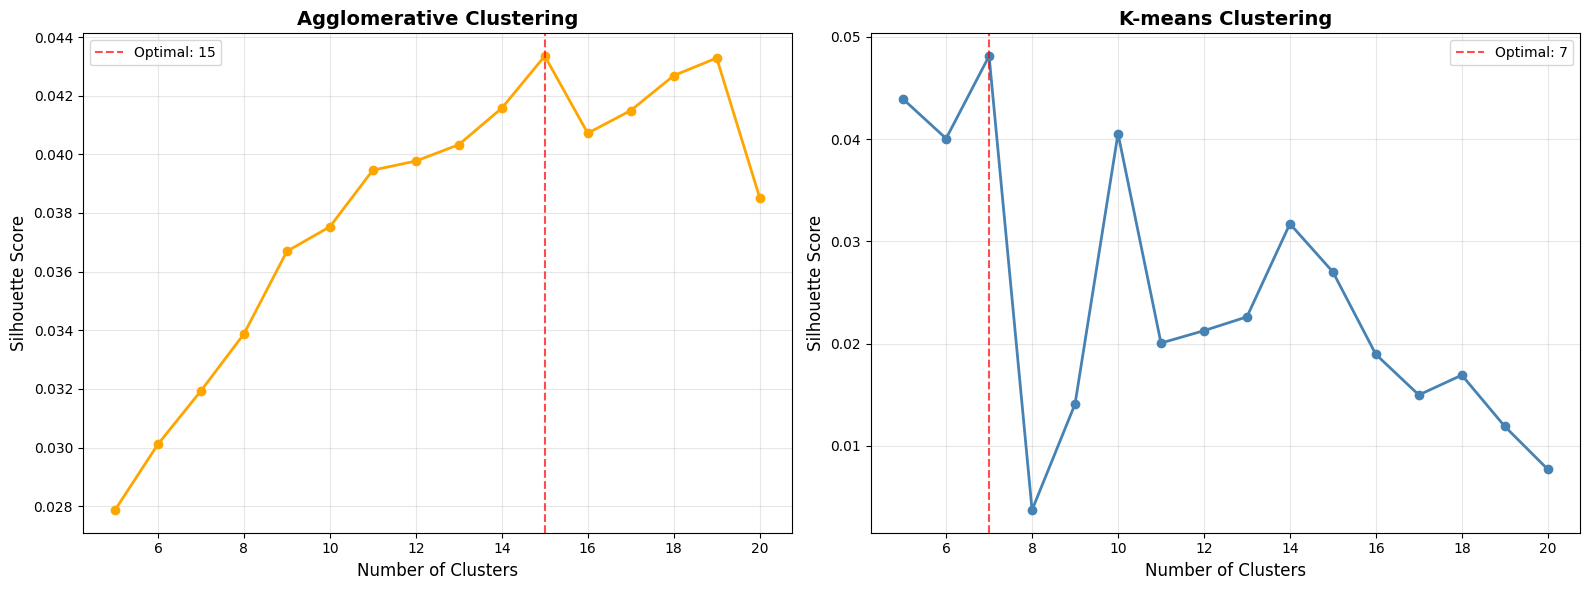

                          AGGLOMERATIVE (15 clusters)                                                         K-MEANS (7 clusters)                              

Cluster  3 (size: 101)                                                          Cluster  6 (size: 114)                                                        
──────────────────────────────────────────────────────────────────────────────  ──────────────────────────────────────────────────────────────────────────────
   1. 命      - life                 (freq:   3886)                                 1. 命      - life                 (freq:   3886)                            
   2. 脑      - brain                (freq:   1812)                                 2. 脑      - brain                (freq:   1812)                            
   3. 口      - mouth                (freq:   1953)                                 3. 电      - electricity          (freq:   1551)                            
   4. 电      - electricity          (freq: 

In [5]:
# Use the top 500 nouns and their BERT embeddings
nouns_top500 = df_noun_top2500.head(500)
embeddings_BERT_top500 = embeddings_BERT[:500]

# Define grid search range
cluster_range = range(5, 21)

# Run grid search for optimal cluster count using both methods
results = run_clustering_grid_search(
    embeddings_BERT_top500, 
    cluster_range, 
    'both',
    plot=True,
)

# Extract results
optimal_agg_clusters = results['optimal_agg_clusters']
optimal_agg_labels = results['optimal_agg_labels']
optimal_kmeans_clusters = results['optimal_kmeans_clusters']
optimal_kmeans_labels = results['optimal_kmeans_labels']

# Get representatives from each cluster
agg_results = get_representative_nouns(
    embeddings_BERT_top500, 
    optimal_agg_labels, 
    nouns_top500, 
    optimal_agg_clusters,
    return_dict=True
)
kmeans_results = get_representative_nouns(
    embeddings_BERT_top500, 
    optimal_kmeans_labels, 
    nouns_top500, 
    optimal_kmeans_clusters,
    return_dict=True
)

# Display side-by-side comparison
display_clusters_side_by_side(
    agg_results,
    kmeans_results,
    optimal_agg_labels, 
    optimal_kmeans_labels,
    max(optimal_agg_clusters, optimal_kmeans_clusters),
    group1_title=f'AGGLOMERATIVE ({optimal_agg_clusters} clusters)',
    group2_title=f'K-MEANS ({optimal_kmeans_clusters} clusters)',
    sort_by='size'
)

---

Agglomerative clustering of the top 500 nouns using the raw BERT embeddings produced 15 clusters, and nine of these showed semantic coherence.

K-means, despite having a higher silhouette score, produced 7 clusters that grouped semantically distinct words too broadly.

To improve scalability and clustering quality, PCA dimensionality reduction will be tested across different component counts.

### PCA Dimensionality Selection

#### Silhouette Score Analysis

Number of clusters:      15
Optimal PCA components:  3
Silhouette score:        0.2421
Explained variance:      14.66%


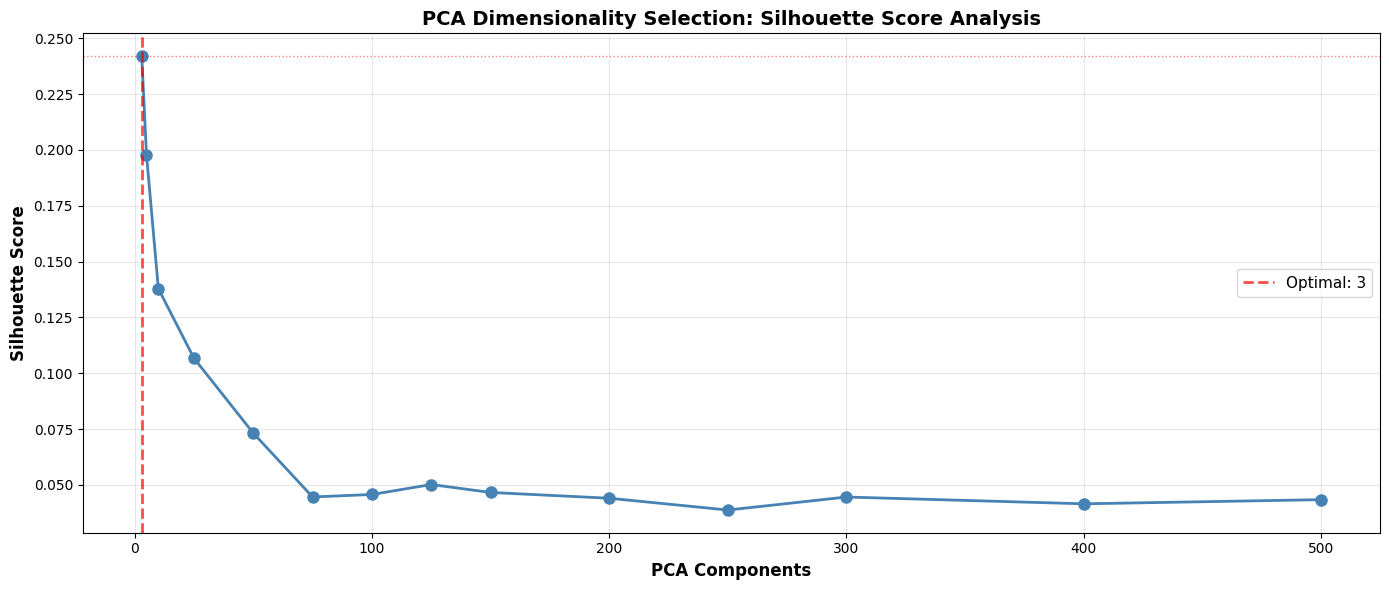


AGGLOMERATIVE CLUSTERING WITH 3 PCA COMPONENTS (15 clusters)

Cluster 0 (size: 79):
  1. 炸弹     - bomb                 (freq: 2268)
  2. 报纸     - newspaper            (freq: 1710)
  3. 同志     - comrade              (freq: 1873)
  4. 灵魂     - soul                 (freq: 2425)
  5. 好运     - good luck            (freq: 3289)
  6. 心脏     - heart                (freq: 1830)
  7. 主意     - idea                 (freq: 6144)
  8. 评委     - judges               (freq: 2253)
  9. 尸体     - corpse               (freq: 4994)
  10. 家族     - family               (freq: 1822)
  11. 客户     - client               (freq: 2168)
  12. 星球     - planet               (freq: 1454)
  13. 子弹     - bullet               (freq: 2488)
  14. 小组     - group                (freq: 1655)
  15. 大脑     - brain                (freq: 1461)
  16. 汽车     - car                  (freq: 2373)
  17. 内心     - heart                (freq: 1444)
  18. 成员     - member               (freq: 2088)
  19. 旅馆     - hostel               (freq:

In [6]:
# Define PCA grid search parameters
pca_components = [3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500]

# Run PCA grid search
pca_results = run_pca_grid_search(
    embeddings_BERT_top500, 
    pca_components, 
    n_clusters=optimal_agg_clusters,
    compute_silhouette=True
)

# Extract results
pca_models_dict = pca_results['pca_models_dict']
pca_embeddings_dict = pca_results['pca_embeddings_dict']
pca_scores = pca_results['pca_scores']

# Get optimal PCA components
optimal_idx = np.argmax(pca_scores)
optimal_pca = pca_components[optimal_idx]
optimal_score = pca_scores[optimal_idx]
optimal_pca_model = pca_models_dict[optimal_pca]

# Print summary
print("=" * 70)
print(f"Number of clusters:      {optimal_agg_clusters}")
print(f"Optimal PCA components:  {optimal_pca}")
print(f"Silhouette score:        {optimal_score:.4f}")
print(f"Explained variance:      {sum(optimal_pca_model.explained_variance_ratio_):.2%}")
print("=" * 70)

# Plot results
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(pca_components, pca_scores, marker='o', linewidth=2, markersize=8, color='steelblue')
ax.axvline(x=optimal_pca, color='r', linestyle='--', alpha=0.7, linewidth=2, label=f'Optimal: {optimal_pca}')
ax.axhline(y=optimal_score, color='r', linestyle=':', alpha=0.5, linewidth=1)
ax.set_xlabel('PCA Components', fontsize=12, fontweight='bold')
ax.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax.set_title('PCA Dimensionality Selection: Silhouette Score Analysis', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Apply optimal PCA and run clustering
optimal_pca_embeddings = pca_embeddings_dict[optimal_pca]
optimal_labels = run_clustering(optimal_pca_embeddings, optimal_agg_clusters)

# Get representatives from each cluster
optimal_results = get_representative_nouns(
    optimal_pca_embeddings, 
    optimal_labels, 
    nouns_top500, 
    optimal_agg_clusters,
    n_representatives=25
)

# Print results
print_representative_nouns(
    optimal_results,
    title=f"AGGLOMERATIVE CLUSTERING WITH {optimal_pca} PCA COMPONENTS ({optimal_agg_clusters} clusters)",
    sort_by='size'
)

---

The PCA grid search selected 3 components as optimal based on silhouette score, but most of the clusters formed had low semantic coherence.

This metric has a critical limitation:

**Silhouette scores measure geometric separation.**

At very low dimensions, geometric compression artificially inflates silhouette scores.

**To properly evaluate PCA dimensionality, cluster quality needs to be validated in the raw embedding space.**

The enhanced analysis below addresses this by computing:
- **Reconstruction fidelity:** How much information does PCA lose?
- **Baseline similarity:** Does PCA preserve the natural clustering structure?
- **Intra-cluster coherence:** Are cluster members semantically similar in the raw embedding space?
- **Inter-centroid separation:** Are clusters distinct in the raw embedding space?

This allows us to distinguish between geometric artifacts and genuine semantic clustering improvements.

#### Enhanced Analysis

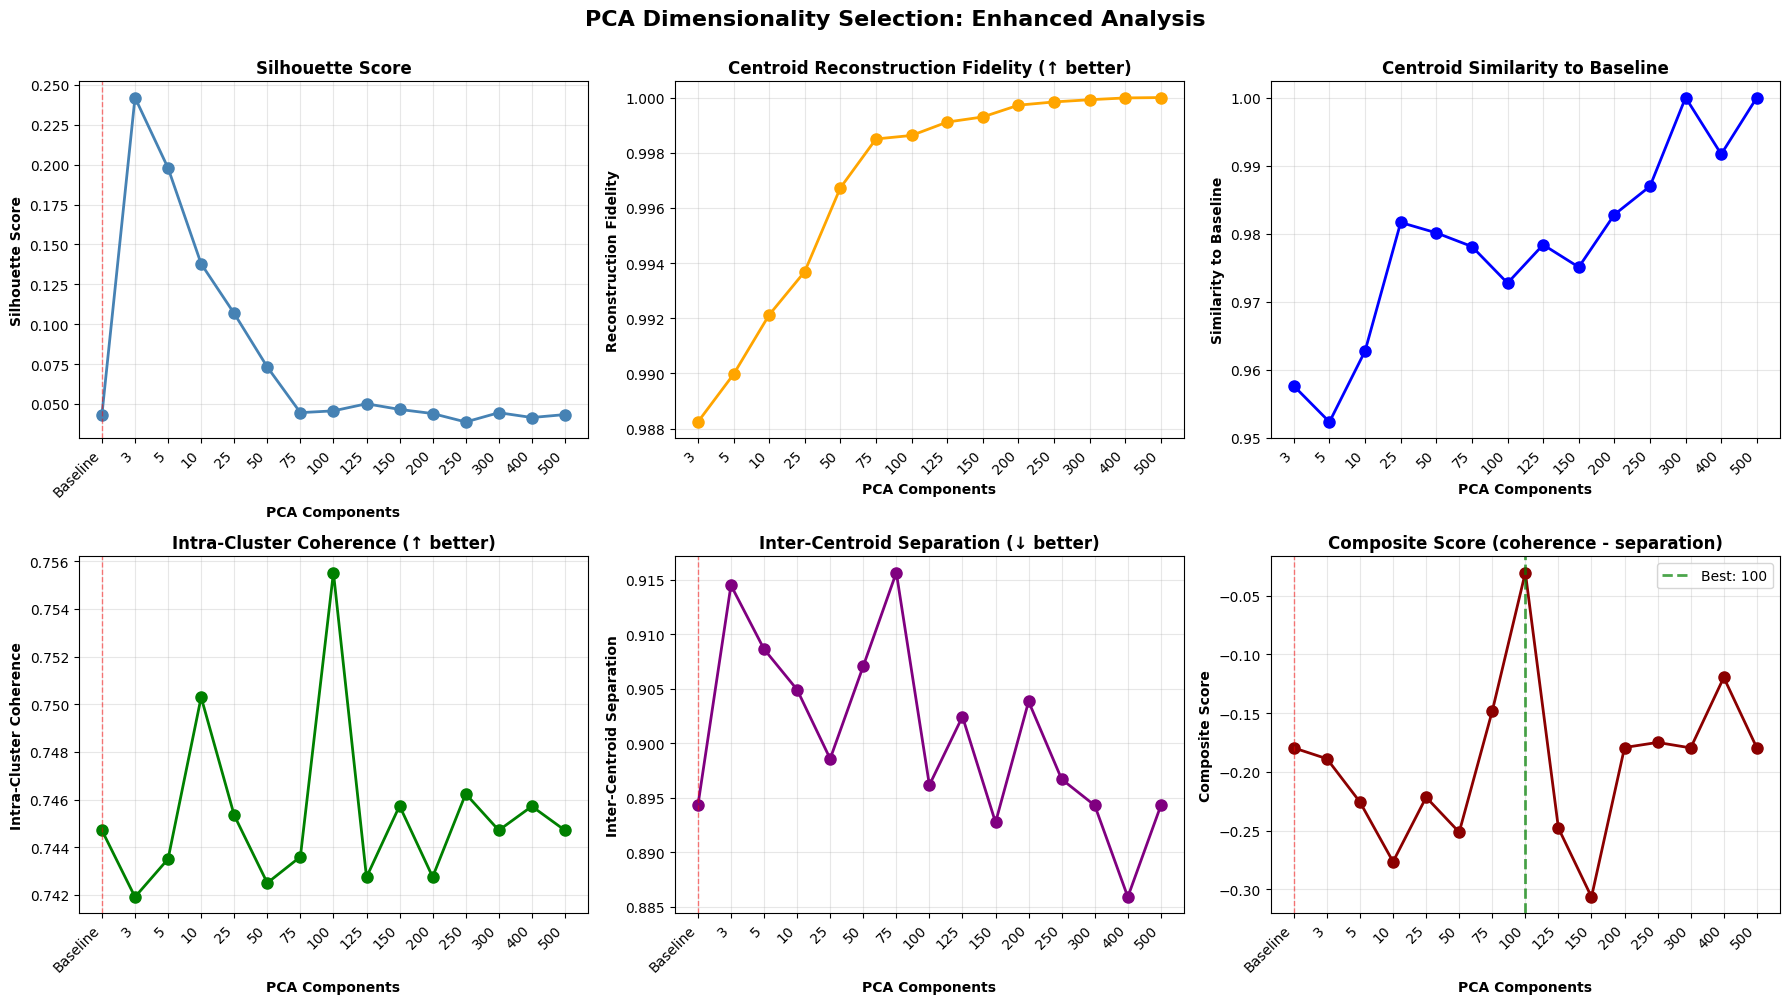

                           BASELINE (RAW EMBEDDINGS)                                               OPTIMAL PCA CONFIGURATION (100 DIMENSIONS)                   

Cluster  3 (size: 101)                                                          Cluster  2 (size:  98)                                                        
──────────────────────────────────────────────────────────────────────────────  ──────────────────────────────────────────────────────────────────────────────
   1. 命      - life                 (freq:   3886)                                 1. 命      - life                 (freq:   3886)                            
   2. 脑      - brain                (freq:   1812)                                 2. 光      - light                (freq:   2694)                            
   3. 口      - mouth                (freq:   1953)                                 3. 菜      - vegetable            (freq:   1963)                            
   4. 电      - electricity          (freq: 

In [7]:
# Define PCA grid search parameters
pca_components = [3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500]

# Run PCA grid search
pca_results = run_pca_grid_search(
    embeddings_BERT_top500,
    pca_components,
    n_clusters=optimal_agg_clusters,
    compute_silhouette=True
)

# Extract results
pca_models_dict = pca_results['pca_models_dict']
pca_embeddings_dict = pca_results['pca_embeddings_dict']
pca_scores = pca_results['pca_scores']

# Compute baseline labels for comparison
baseline_labels = run_clustering(embeddings_BERT_top500, optimal_agg_clusters)

# Compute baseline centroids in raw embedding space
baseline_centroids = []
for i in range(optimal_agg_clusters):
    cluster_mask = baseline_labels == i
    centroid = embeddings_BERT_top500[cluster_mask].mean(axis=0)
    baseline_centroids.append(centroid)
baseline_centroids = np.array(baseline_centroids)

# Create a list to store grid search results
pca_summary = []

# Compute metrics for baseline
baseline_metrics_df = compute_enhanced_metrics(
    embeddings_BERT_top500, embeddings_BERT_top500, baseline_labels, 
    optimal_agg_clusters, baseline_centroids, pca_transformer=None
)

# Add results to list
pca_summary.append({
    'pca_components': 'Baseline',
    'mean_intra_coherence': baseline_metrics_df['intra_coherence'].mean(),
    'mean_inter_separation': baseline_metrics_df['inter_separation'].mean(),
    'mean_baseline_similarity': baseline_metrics_df['baseline_similarity'].mean(),
    'mean_reconstruction_fidelity': baseline_metrics_df['reconstruction_fidelity'].mean(),
    'mean_composite_score': baseline_metrics_df['composite_score'].mean(),
    'silhouette_score': silhouette_score(embeddings_BERT_top500, baseline_labels)
})

# Iterate over PCA components
for i, n_components in enumerate(pca_components):
    pca_embeddings = pca_embeddings_dict[n_components]
    pca_model = pca_models_dict[n_components]
    
    # Compute labels
    labels = run_clustering(pca_embeddings, optimal_agg_clusters)
    
    # Compute metrics
    metrics_df = compute_enhanced_metrics(
        pca_embeddings, embeddings_BERT_top500, labels, optimal_agg_clusters,
        baseline_centroids, pca_transformer=pca_model
    )
    
    # Add results to list
    pca_summary.append({
        'pca_components': n_components,
        'mean_intra_coherence': metrics_df['intra_coherence'].mean(),
        'mean_inter_separation': metrics_df['inter_separation'].mean(),
        'mean_baseline_similarity': metrics_df['baseline_similarity'].mean(),
        'mean_reconstruction_fidelity': metrics_df['reconstruction_fidelity'].mean(),
        'mean_composite_score': metrics_df['composite_score'].mean(),
        'silhouette_score': pca_scores[i],
        'explained_variance': pca_model.explained_variance_ratio_.sum()
    })

# Convert results list to dataframe
summary_metrics = pd.DataFrame(pca_summary)

# Plot results
plot_pca_enhanced_analysis(summary_metrics)

# Find optimal PCA configuration based on composite score
pca_configs = summary_metrics[summary_metrics['pca_components'] != 'Baseline']
optimal_composite_idx = pca_configs['mean_composite_score'].idxmax()
optimal_pca_components = summary_metrics.iloc[optimal_composite_idx]['pca_components']
optimal_pca_embeddings = pca_embeddings_dict[optimal_pca_components]

# Compute labels
optimal_pca_labels = run_clustering(optimal_pca_embeddings, optimal_agg_clusters)

# Get representative nouns
optimal_pca_results = get_representative_nouns(
    optimal_pca_embeddings,
    optimal_pca_labels,
    nouns_top500, 
    optimal_agg_clusters,
    n_representatives=25,
    return_dict=True
)

# Get representative nouns for baseline
baseline_results = get_representative_nouns(
    embeddings_BERT_top500,
    baseline_labels,
    nouns_top500, 
    optimal_agg_clusters,
    n_representatives=25,
    return_dict=True
)

# Display side-by-side
display_clusters_side_by_side(
    baseline_results,
    optimal_pca_results,
    baseline_labels,
    optimal_pca_labels, 
    optimal_agg_clusters,
    group1_title='BASELINE (RAW EMBEDDINGS)',
    group2_title=f'OPTIMAL PCA CONFIGURATION ({optimal_pca_components} DIMENSIONS)',
    sort_by='size'
)

---

Using the same cluster count of 15 for direct comparison, agglomerative clustering after reduction to 100 PCA dimensions produced 10 semantically coherent clusters. Many of these had a much cleaner structure than the clusters created from the raw embeddings.

With PCA reduction established, different vocabulary sizes will be tested and optimal cluster count will be reassessed.

## Clustering Analysis

### Top 500

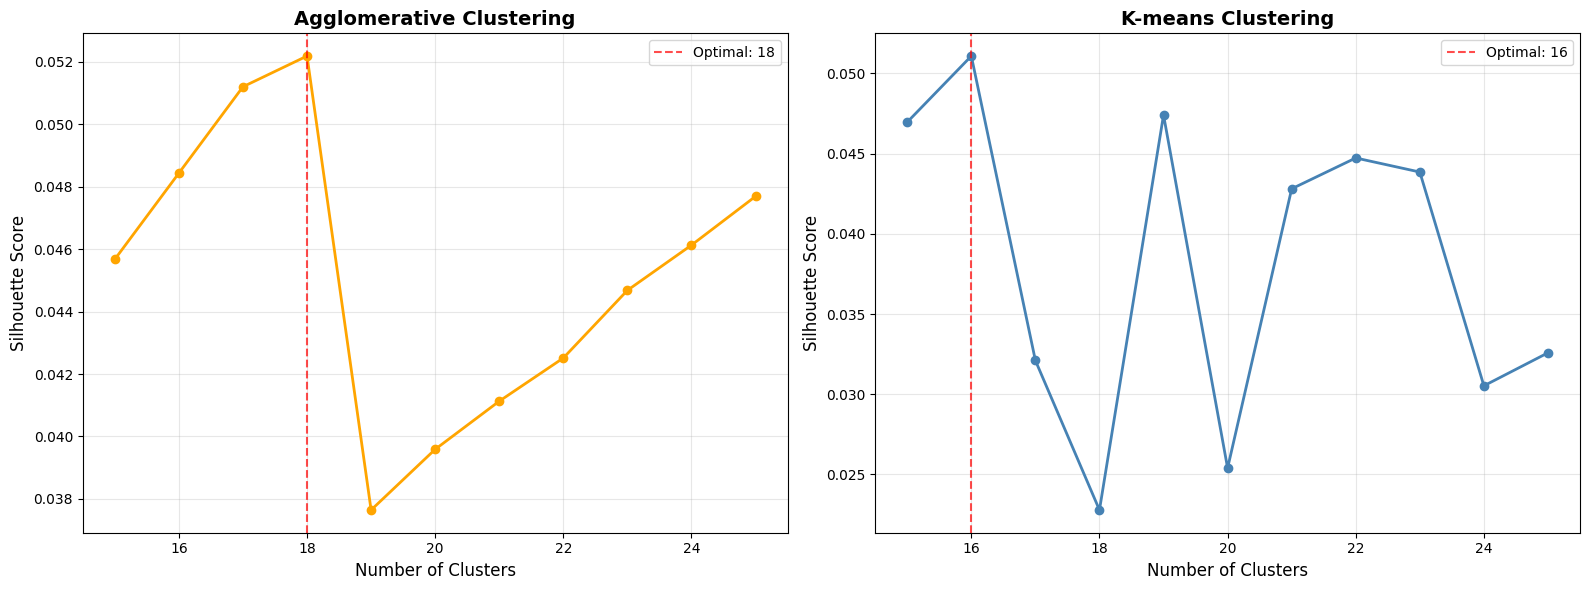

                          AGGLOMERATIVE (18 clusters)                                                        K-MEANS (16 clusters)                              

Cluster  0 (size:  98)                                                          Cluster  6 (size:  93)                                                        
──────────────────────────────────────────────────────────────────────────────  ──────────────────────────────────────────────────────────────────────────────
   1. 命      - life                 (freq:   3886)                                 1. 命      - life                 (freq:   3886)                            
   2. 光      - light                (freq:   2694)                                 2. 菜      - vegetable            (freq:   1963)                            
   3. 菜      - vegetable            (freq:   1963)                                 3. 光      - light                (freq:   2694)                            
   4. 电      - electricity          (freq: 

In [8]:
# Fit 100-dimension PCA
pca100_top500 = PCA(n_components=100, random_state=42)
embeddings_BERT_top500_pca100 = pca100_top500.fit_transform(embeddings_BERT_top500)

# Define grid search range
cluster_range = range(15, 26)

# Run grid search for optimal cluster count using both methods
results = run_clustering_grid_search(
    embeddings_BERT_top500_pca100, 
    cluster_range, 
    'both',
    plot=True,
)

# Extract results
optimal_agg_clusters = results['optimal_agg_clusters']
optimal_agg_labels = results['optimal_agg_labels']
optimal_kmeans_clusters = results['optimal_kmeans_clusters']
optimal_kmeans_labels = results['optimal_kmeans_labels']

# Get representatives from each cluster
agg_results = get_representative_nouns(
    embeddings_BERT_top500_pca100, 
    optimal_agg_labels, 
    nouns_top500, 
    optimal_agg_clusters,
    return_dict=True
)
kmeans_results = get_representative_nouns(
    embeddings_BERT_top500_pca100, 
    optimal_kmeans_labels, 
    nouns_top500, 
    optimal_kmeans_clusters,
    return_dict=True
)

# Display side-by-side comparison
display_clusters_side_by_side(
    agg_results,
    kmeans_results,
    optimal_agg_labels, 
    optimal_kmeans_labels,
    max(optimal_agg_clusters, optimal_kmeans_clusters),
    group1_title=f'AGGLOMERATIVE ({optimal_agg_clusters} clusters)',
    group2_title=f'K-MEANS ({optimal_kmeans_clusters} clusters)',
    sort_by='size'
)

---

After reducing to 100 PCA dimensions, K-means continued to struggle with forming coherent clusters, and will therefore be omitted from subsequent analyses.

Agglomerative clustering performed better with 18 clusters than with 15, resulting in 12 semantically coherent groups rather than 10.

To investigate whether additional vocabulary improves cluster resolution, the analysis will be repeated with the top 1000 nouns.

### Top 1000

In [9]:
# Get top 1000 nouns and their BERT embeddings
nouns_top1000 = df_noun_top2500.head(1000)
embeddings_BERT_top1000 = embeddings_BERT[:1000]

# Fit 100-dimension PCA
pca100_top1000 = PCA(n_components=100, random_state=42)
embeddings_BERT_top1000_pca100 = pca100_top1000.fit_transform(embeddings_BERT_top1000)

# Define number of clusters
n_clusters = 18

# Process top 500
labels_top500 = run_clustering(embeddings_BERT_top500_pca100, n_clusters)
results_top500 = get_representative_nouns(
    embeddings_BERT_top500_pca100, 
    labels_top500, 
    nouns_top500, 
    n_clusters,
    return_dict=True
)

# Process top 1000
labels_top1000 = run_clustering(embeddings_BERT_top1000_pca100, n_clusters)
results_top1000 = get_representative_nouns(
    embeddings_BERT_top1000_pca100, 
    labels_top1000, 
    nouns_top1000, 
    n_clusters,
    return_dict=True
)

# Display clusters side-by-side
display_clusters_side_by_side(
    results_top500,
    results_top1000,
    labels_top500,
    labels_top1000,
    n_clusters,
    group1_title='TOP 500',
    group2_title='TOP 1000',
    n_shared_words=500,
    sort_by='size'
)

                                    TOP 500                                                                         TOP 1000                                    

Cluster  0 (size:  98)                                                          Cluster 15 (size: 140)                                                        
──────────────────────────────────────────────────────────────────────────────  ──────────────────────────────────────────────────────────────────────────────
   1. 命      - life                 (freq:   3886)                                 1. 光      - light                (freq:   2694)                            
   2. 光      - light                (freq:   2694)                                 2. 菜      - vegetable            (freq:   1963)                            
   3. 菜      - vegetable            (freq:   1963)                                 3. 命      - life                 (freq:   3886)                            
   4. 电      - electricity          (freq: 

---

Expanding to 1000 words caused a slight decline in clustering quality. Though many stable clusters persisted, the number of coherent clusters dropped to 11, and heterogeneous clusters absorbed a greater share of the vocabulary.

A larger range of cluster counts will be tested to determine whether finer granularity helps to maintain semantic coherence.

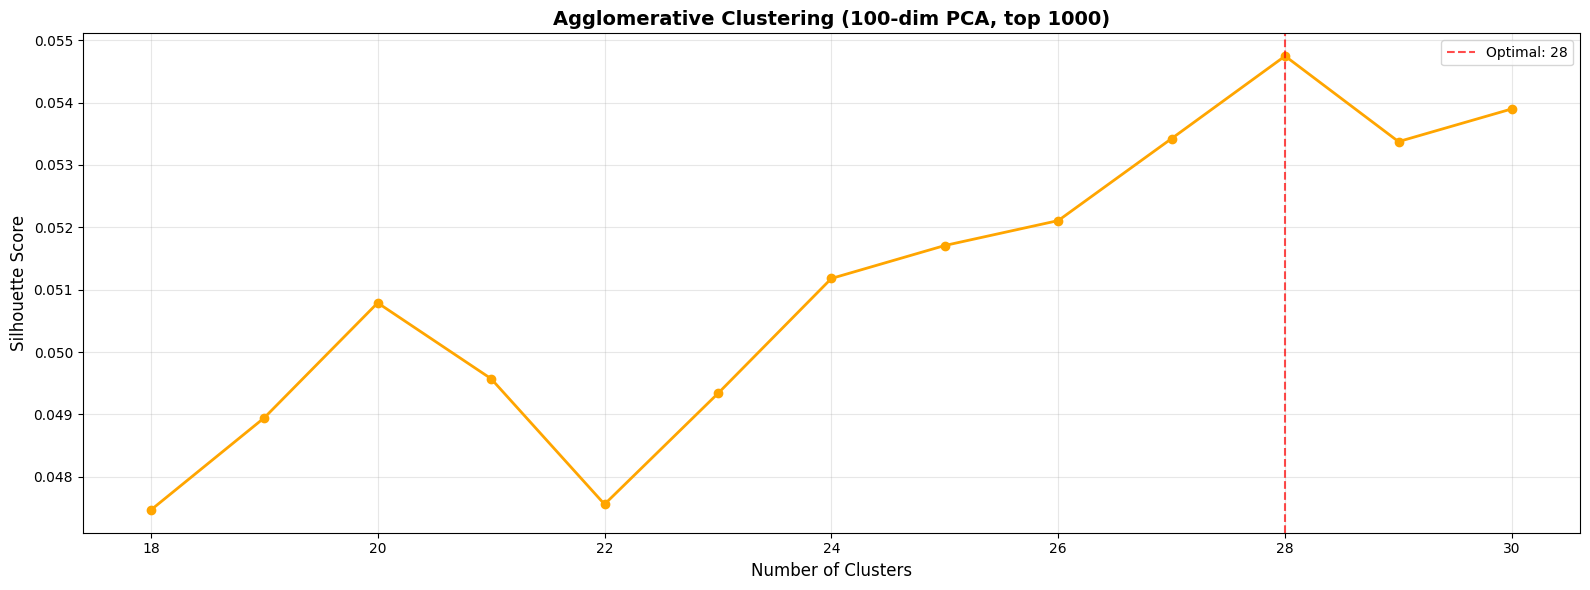


AGGLOMERATIVE CLUSTERING (100-DIM PCA, TOP 1000) - 28 CLUSTERS

Cluster 15 (size: 140):
  1. 光      - light                (freq: 2694)
  2. 菜      - vegetable            (freq: 1963)
  3. 命      - life                 (freq: 3886)
  4. 电      - electricity          (freq: 1551)
  5. 牌      - card                 (freq: 2091)
  6. 脑      - brain                (freq: 1812)
  7. 水      - water                (freq: 7581)
  8. 货      - goods                (freq: 1486)
  9. 眼      - eye                  (freq: 2236)
  10. 票      - ticket               (freq: 2373)
  11. 口      - mouth                (freq: 1953)
  12. 米      - rice                 (freq: 1545)
  13. 歌      - song                 (freq: 6285)
  14. 皮      - skin                 (freq: 2171)
  15. 声      - voice                (freq: 887)
  16. 牙      - tooth                (freq: 1221)
  17. 本      - book                 (freq: 1125)
  18. 手      - hand                 (freq: 14984)
  19. 人      - people               (f

In [10]:
# Define grid search range
cluster_range = range(18, 31)

# Run grid search for optimal cluster count
optimal_clusters, labels = run_clustering_grid_search(
    embeddings_BERT_top1000_pca100, 
    cluster_range, 
    'agg',
    plot=True,
    title='Agglomerative Clustering (100-dim PCA, top 1000)'
)

# Get representatives from each cluster
results = get_representative_nouns(
    embeddings_BERT_top1000_pca100, 
    labels, 
    nouns_top1000, 
    optimal_clusters
)

# Print results
print_representative_nouns(
    results,
    title=f"AGGLOMERATIVE CLUSTERING (100-DIM PCA, TOP 1000) - {optimal_clusters} CLUSTERS",
    sort_by='size'
)

---

A silhouette score sweep identified 28 clusters as optimal, producing 23 semantically coherent groups. Far fewer words fell into heterogeneous clusters compared to the previous analysis.

Interestingly, two clusters grouped words by shared characters (人 and 子), suggesting the embeddings captured morphological similarity rather than semantic meaning.

### Top 2500

In [11]:
# Get top 2500 nouns and their BERT embeddings (redundant but done for consistency)
nouns_top2500 = df_noun_top2500.head(2500)
embeddings_BERT_top2500 = embeddings_BERT[:2500]

# Fit 100-dimension PCA
pca100_top2500 = PCA(n_components=100, random_state=42)
embeddings_BERT_top2500_pca100 = pca100_top2500.fit_transform(embeddings_BERT_top2500)

# Define number of clusters
n_clusters = 28

# Process top 1000
labels_top1000 = run_clustering(embeddings_BERT_top1000_pca100, n_clusters)
results_top1000 = get_representative_nouns(
    embeddings_BERT_top1000_pca100, 
    labels_top1000, 
    nouns_top1000, 
    n_clusters,
    return_dict=True
)

# Process top 2500
labels_top2500 = run_clustering(embeddings_BERT_top2500_pca100, n_clusters)
results_top2500 = get_representative_nouns(
    embeddings_BERT_top2500_pca100, 
    labels_top2500, 
    nouns_top2500, 
    n_clusters,
    return_dict=True
)

# Display clusters side-by-side
display_clusters_side_by_side(
    results_top1000,
    results_top2500,
    labels_top1000,
    labels_top2500,
    n_clusters,
    group1_title='TOP 1000',
    group2_title='TOP 2500',
    n_shared_words=1000,
    sort_by='size'
)

                                    TOP 1000                                                                        TOP 2500                                    

Cluster 15 (size: 140)                                                          Cluster 15 (size: 249)                                                        
──────────────────────────────────────────────────────────────────────────────  ──────────────────────────────────────────────────────────────────────────────
   1. 光      - light                (freq:   2694)                                 1. 命      - life                 (freq:   3886)                            
   2. 菜      - vegetable            (freq:   1963)                                 2. 劲      - strength             (freq:    627)                            
   3. 命      - life                 (freq:   3886)                                 3. 萝      - radish               (freq:    672)                            
   4. 电      - electricity          (freq: 

---

As in the jump from 500 to 1000 words, expanding the vocabulary size led to a higher proportion of heterogeneous clusters.

However, unlike the previous transition, the expansion to 2500 words resulted in a slight increase in clustering quality. 

To maintain semantic purity at 2500 nouns, a greater number of clusters is likely required.

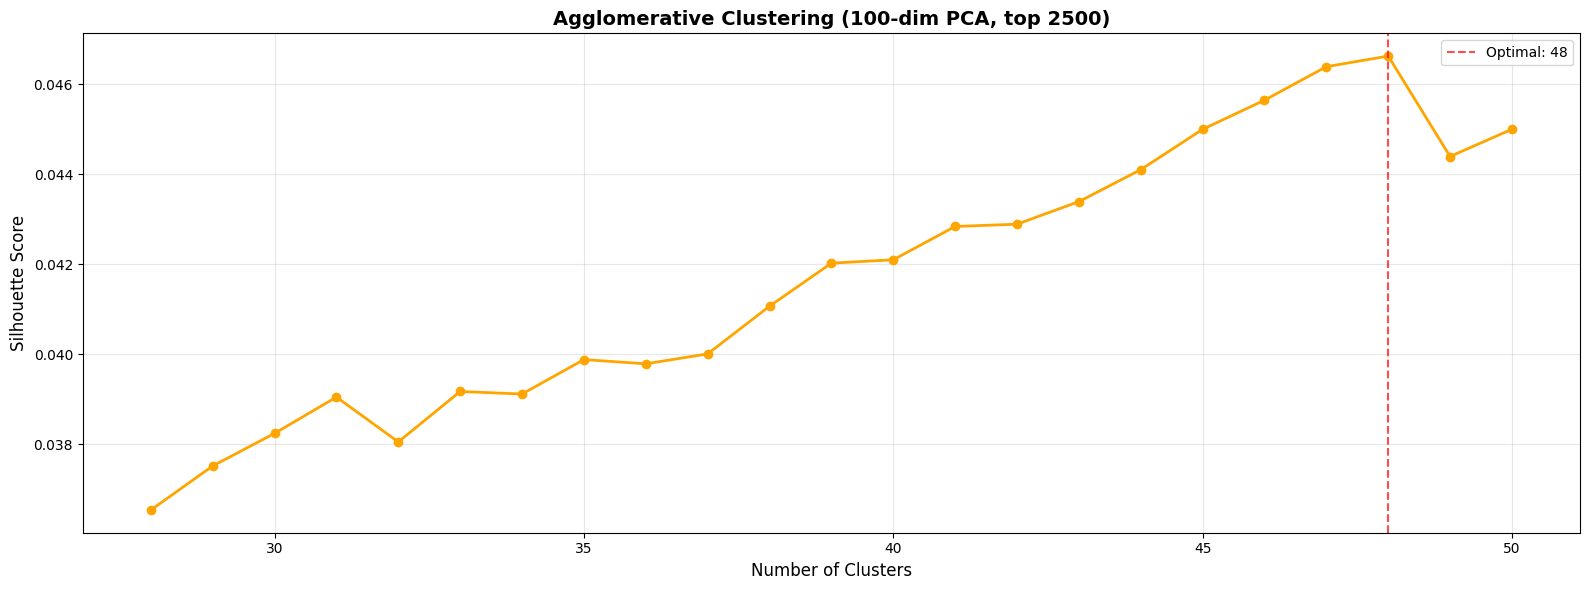


AGGLOMERATIVE CLUSTERING (100-DIM PCA, TOP 2500) - 48 CLUSTERS

Cluster 31 (size: 249):
  1. 命      - life                 (freq: 3886)
  2. 劲      - strength             (freq: 627)
  3. 萝      - radish               (freq: 672)
  4. 款      - payment              (freq: 349)
  5. 脑      - brain                (freq: 1812)
  6. 电      - electricity          (freq: 1551)
  7. 菜      - vegetable            (freq: 1963)
  8. 光      - light                (freq: 2694)
  9. 瘾      - addiction            (freq: 261)
  10. 像      - picture              (freq: 339)
  11. 膜      - membrane             (freq: 252)
  12. 耳      - ear                  (freq: 503)
  13. 胶      - glue                 (freq: 343)
  14. 器      - device               (freq: 592)
  15. 货      - goods                (freq: 1486)
  16. 所      - place                (freq: 511)
  17. 牌      - card                 (freq: 2091)
  18. 口      - mouth                (freq: 1953)
  19. 皮      - skin                 (freq: 2171)

In [12]:
# Define grid search range
cluster_range = range(28, 51)

# Run grid search for optimal cluster count
optimal_clusters, labels = run_clustering_grid_search(
    embeddings_BERT_top2500_pca100, 
    cluster_range, 
    'agg',
    plot=True,
    title='Agglomerative Clustering (100-dim PCA, top 2500)'
)

# Get representatives from each cluster
results = get_representative_nouns(
    embeddings_BERT_top2500_pca100, 
    labels, 
    nouns_top2500, 
    optimal_clusters
)

# Print results
print_representative_nouns(
    results,
    title=f"AGGLOMERATIVE CLUSTERING (100-DIM PCA, TOP 2500) - {optimal_clusters} CLUSTERS",
    sort_by='size'
)

---

The extra-wide grid search identified 48 clusters as optimal. Of these, 39 were semantically coherent.

Additionally, only 37.3% of the vocabulary fell into heterogeneous clusters - the lowest across all configurations tested.

## Results

### Summary Table

| Dimensions | Words | Clusters (Agglomerative) | Coverage | Quality |
|:---:|:---:|:---:|:---:|:---:|
| Raw (768) | 500 | 15 | 40.6% | 55.6% |
| PCA (100) | 500 | 15 | 42.6% | 80.0% |
| PCA (100) | 500 | 18 | 46.6% | 75.0% |
| PCA (100) | 1000 | 18 | 38.4% | 72.7% |
| PCA (100) | 1000 | 28 | 60.5% | 78.3% |
| PCA (100) | 2500 | 28 | 53.2% | 81.0% |
| PCA (100) | 2500 | 48 | 62.5% | 82.1% |

Coverage and quality were determined through manual inspection of cluster outputs:

- **Coverage** represents the percentage of vocabulary successfully organised into semantically coherent clusters

- **Quality** measures the percentage of coherent clusters that achieved near-perfect semantic cohesion

Each vocabulary size uses its own fitted 100-dimensional PCA transformation to ensure optimal dimensionality reduction at that scale. This approach evaluates best-case clustering performance at each vocabulary level, rather than tracking cluster evolution in a fixed embedding space. 

Silhouette scores proved unreliable for PCA dimensionality selection, but were useful for cluster count selection, as geometric separation correlated well with semantic coherence in the fixed 100-dimensional space.

### Key Findings

1. BERT embeddings encode both semantic and morphological features. Single-character nouns consistently clustered together across all vocabulary sizes, whilst other groups organised by shared character components (人, 子, 色) rather than meaning.

2. A ceiling exists around 60% vocabulary coverage, regardless of parameter optimisation. This suggests that a significant portion of high-frequency Chinese nouns resist clean semantic categorisation.

3. Expanding vocabulary requires proportionally more clusters to maintain semantic coherence.

4. PCA is extremely effective for improving cluster quality.

### Recommended Configuration

`n=2500/k=48` achieved the best coverage and quality, but may be too granular for effective visualization.

`n=1000/k=28` offers a strong alternative, balancing good performance with more interpretable granularity.

In [13]:
# Compute labels for n=1000/k=28
n_clusters = 28
labels = run_clustering(embeddings_BERT_top1000_pca100, n_clusters)

# Save results
save_data_BERT_top1000_pca100 = {
    'labels': labels,
    'embeddings': embeddings_BERT_top1000_pca100,
    'n_clusters': n_clusters,
    'nouns_df': nouns_top1000.copy()
}

# Dump to pickle
with open('data/noun_clusters_BERT_top1000_pca100.pkl', 'wb') as f:
    pickle.dump(save_data_BERT_top1000_pca100, f)